<a href="https://www.kaggle.com/code/ranjanrakesh51/identify-loyal-lost-customers-best-products?scriptVersionId=246660954" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Table of Contents

1.  [**Data Loading & Initial Inspection**](#1-data-loading--initial-inspection)
2.  [**Data Cleaning & Preprocessing**](#2-data-cleaning--preprocessing)
3.  [**Feature Engineering**](#3-feature-engineering)
4.  [**Exploratory Data Analysis (EDA) & Visualization**](#4-exploratory-data-analysis-eda--visualization)
    * [Total Sales by Month](#total-sales-by-month)
    * [Total Sales by Day of Week](#total-sales-by-day-of-week)
    * [Total Sales by Hour of Day](#total-sales-by-hour-of-day)
    * [Top 10 Best-Selling Products by Quantity](#top-10-best-selling-products-by-quantity)
    * [Top 10 Best-Selling Products by Revenue](#top-10-best-selling-products-by-revenue)
    * [Top 10 Countries by Total Sales (Excluding UK)](#top-10-countries-by-total-sales-excluding-uk)
5.  [**RFM Analysis (Recency, Frequency, Monetary)**](#5-rfm-analysis-recency-frequency-monetary)
    * [RFM Metric Calculation](#rfm-metric-calculation)
    * [RFM Score Assignment](#rfm-score-assignment)
    * [Customer Segmentation](#customer-segmentation)
    * [Distribution of Customer Segments](#distribution-of-customer-segments)
6.  [**Conclusion and Recommendations**](#6-conclusion-and-recommendations)
    * [Summary of Key Insights](#summary-of-key-insights)
    * [Data-Driven Recommendations](#data-driven-recommendations)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# 1. Data Loading & Initial Inspection

In [2]:
try:
    df = pd.read_excel('/kaggle/input/online-retail/Online Retail.xlsx')
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'Online Retail.xlsx' not found. Please ensure the file is in the correct directory or provide the full path.")
    exit()

Dataset loaded successfully!


In [3]:
print('\nDataset Shape:',df.shape)
df.head()


Dataset Shape: (541909, 8)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
print("\nDescriptive Statistics for Numerical Columns:")
df.describe()


Descriptive Statistics for Numerical Columns:


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


# 2. Data Cleaning & Preprocessing

In [6]:
# Check for missing values
print("\nMissing values before cleaning:")
df.isnull().sum().reset_index()


Missing values before cleaning:


,index,0
0,InvoiceNo,0
1,StockCode,0
2,Description,1454
3,Quantity,0
4,InvoiceDate,0
5,UnitPrice,0
6,CustomerID,135080
7,Country,0



* Handle missing CustomerID: Drop rows where CustomerID is NaN, as it's crucial for customer analysis.
* Convert CustomerID to integer after dropping NaNs to ensure consistency.
* Handle missing Description: Fill with 'Unknown'


In [7]:

df = df.dropna(subset=['CustomerID'])
df['CustomerID'] = df['CustomerID'].astype(int)
print(f"\nShape after dropping rows with missing CustomerID: {df.shape}")

df['Description'] = df['Description'].fillna('Unknown',)
print(f"\nMissing descriptions handled. Remaining missing values:\n{df.isnull().sum()}")



Shape after dropping rows with missing CustomerID: (406829, 8)

Missing descriptions handled. Remaining missing values:
InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64


* Remove duplicate rows

In [8]:
initial_rows = df.shape[0]
df.drop_duplicates(inplace=True)
print(f"\nRemoved {initial_rows - df.shape[0]} duplicate rows.")
print(f"Shape after removing duplicates: {df.shape}")


Removed 5225 duplicate rows.
Shape after removing duplicates: (401604, 8)


* Remove transactions with non-positive Quantity or UnitPrice
* Quantity must be positive (no returns for this analysis phase)
* UnitPrice must be positive (no free items or errors)

In [9]:
df = df[df['Quantity'] > 0]
df = df[df['UnitPrice'] > 0]
print(f"\nShape after removing non-positive Quantity/UnitPrice: {df.shape}")


Shape after removing non-positive Quantity/UnitPrice: (392692, 8)


* Remove cancelled orders (InvoiceNo usually starts with 'C')
* Although Quantity > 0 already filters out returns, it's good practice to ensure
* We are dealing with actual sales transactions.

In [10]:
df = df[~df['InvoiceNo'].astype(str).str.contains('^C',regex=True)]
print(f"Shape after removing cancelled orders (InvoiceNo starting with 'C'): {df.shape}")

Shape after removing cancelled orders (InvoiceNo starting with 'C'): (392692, 8)


# 3. Feature Engineering

* Calculate TotalPrice for each transaction line item
* Extract time-based features from InvoiceDate
* Monday=0, Sunday=6
* Abbreviated month name (e.g., Jan, Feb)
* Full day name (e.g., Monday)

In [11]:
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
print("\n'TotalPrice' column created.")


'TotalPrice' column created.


In [12]:
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek 
df['Hour'] = df['InvoiceDate'].dt.hour
df['MonthName'] = df['InvoiceDate'].dt.strftime('%b') 
df['DayName'] = df['InvoiceDate'].dt.day_name() 
print("Time-based features (Year, Month, Day, DayOfWeek, Hour, MonthName, DayName) created.")

df.head()

Time-based features (Year, Month, Day, DayOfWeek, Hour, MonthName, DayName) created.


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day,DayOfWeek,Hour,MonthName,DayName
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1,2,8,Dec,Wednesday
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,Dec,Wednesday
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1,2,8,Dec,Wednesday
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,Dec,Wednesday
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1,2,8,Dec,Wednesday


# 4. Exploratory Data Analysis (EDA) & Visualization

## Total Sales by Month

* Set up the aesthetic for plots.
* Total sales over time (monthly trend)
* Plot Monthly Sales

In [13]:
monthly_sales = df.groupby('MonthName')['TotalPrice'].sum().reindex(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
print("\nTotal Sales by Month:")
monthly_sales.reset_index()


Total Sales by Month:


,MonthName,TotalPrice
0,Jan,568101.310
1,Feb,446084.920
2,Mar,594081.760
3,Apr,468374.331
4,May,677355.150
5,Jun,660046.050
6,Jul,598962.901
7,Aug,644051.040
8,Sep,950690.202
9,Oct,1035642.450


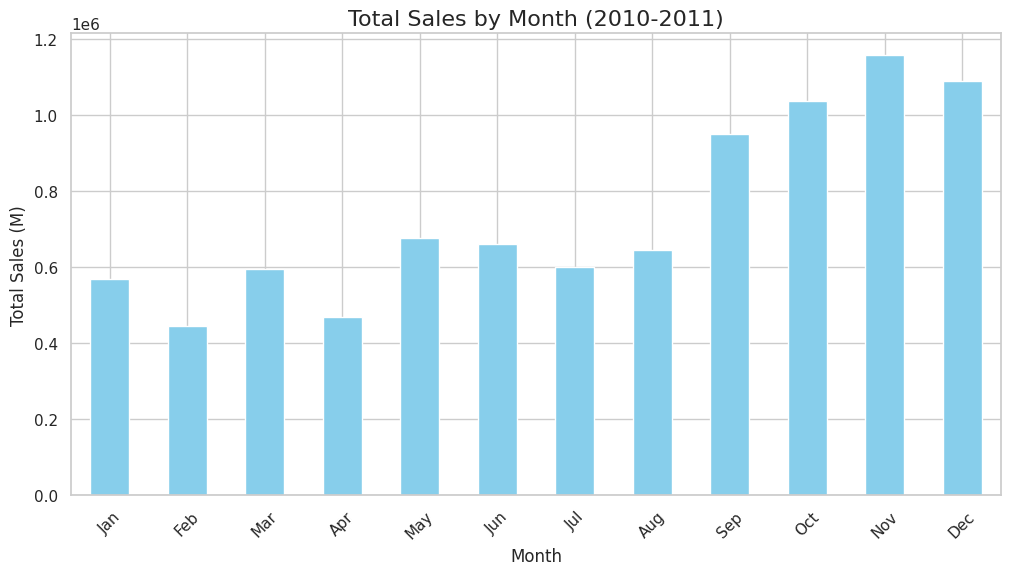

In [14]:
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))

monthly_sales.plot(kind='bar', color='skyblue')
plt.title('Total Sales by Month (2010-2011)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Sales (M)', fontsize=12)
plt.xticks(rotation=45);

## Total Sales by Day of Week

* No data available for saturday
* May be closed on weekend.
* Sales by weekdays.
* Plot Day of week sales.

In [15]:
list(df['DayName'].unique())

['Wednesday', 'Thursday', 'Friday', 'Sunday', 'Monday', 'Tuesday']

In [16]:
day_of_week_sales = df.groupby('DayName')['TotalPrice'].sum().reindex(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Sunday'])
print("\nTotal Sales by Day of Week:")
day_of_week_sales.reset_index()


Total Sales by Day of Week:


,DayName,TotalPrice
0,Monday,1363604.401
1,Tuesday,1697733.801
2,Wednesday,1584283.830
3,Thursday,1973015.730
4,Friday,1483080.811
5,Sunday,785490.321


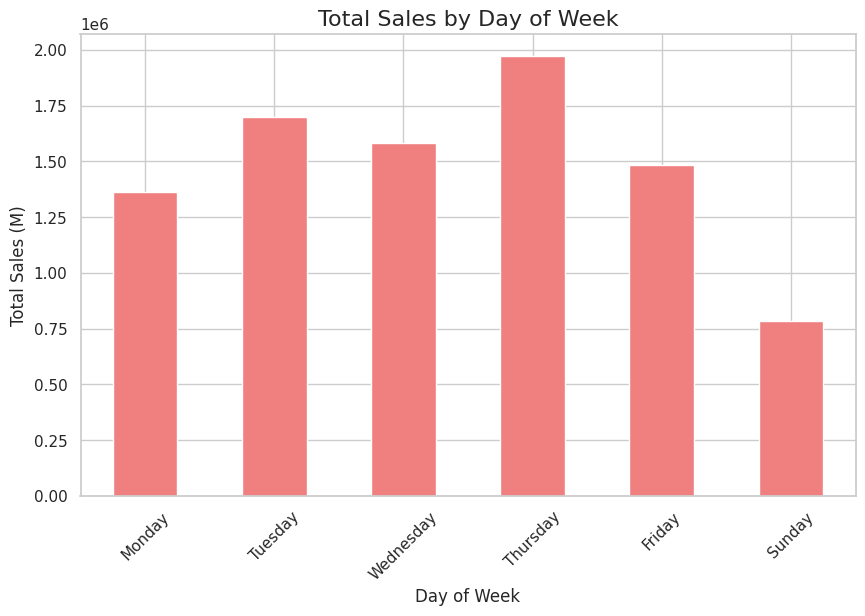

In [17]:
plt.figure(figsize=(10, 6))
day_of_week_sales.plot(kind='bar', color='lightcoral')
plt.title('Total Sales by Day of Week', fontsize=16)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Sales (M)', fontsize=12)
plt.xticks(rotation=45);

## Total Sales by Hour of Day

* Stores open from 6AM to 8PM
* Hourly Sales
* Plot huorly sales

In [18]:
hourly_sales = df.groupby('Hour')['TotalPrice'].sum()
print("\nTotal Sales by Hour of Day:")
hourly_sales.reset_index()


Total Sales by Hour of Day:


,Hour,TotalPrice
0,6,4.250
1,7,31059.210
2,8,281997.790
3,9,842392.341
4,10,1259267.591
5,11,1101177.600
6,12,1373695.390
7,13,1168724.200
8,14,991992.821
9,15,963559.680


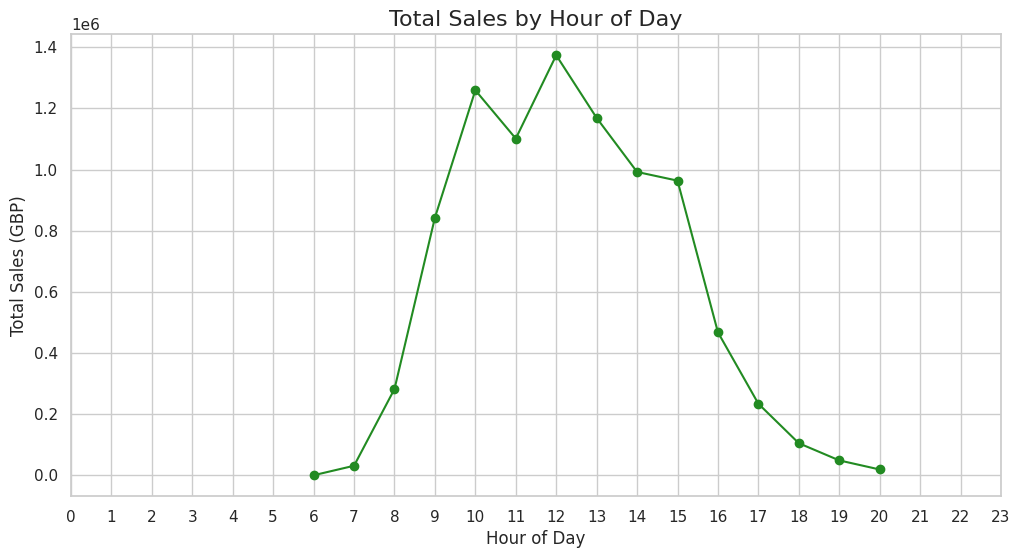

In [19]:
plt.figure(figsize=(12, 6))
hourly_sales.plot(kind='line', marker='o', color='forestgreen')
plt.title('Total Sales by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day', fontsize=12)
plt.ylabel('Total Sales (GBP)', fontsize=12)
plt.xticks(range(0, 24));

## Top 10 Best-Selling Products by Quantity

In [20]:
top_products_quantity = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Best-Selling Products by Quantity:")
top_products_quantity.reset_index()


Top 10 Best-Selling Products by Quantity:


,Description,Quantity
0,"PAPER CRAFT , LITTLE BIRDIE",80995
1,MEDIUM CERAMIC TOP STORAGE JAR,77916
2,WORLD WAR 2 GLIDERS ASSTD DESIGNS,54319
3,JUMBO BAG RED RETROSPOT,46078
4,WHITE HANGING HEART T-LIGHT HOLDER,36706
5,ASSORTED COLOUR BIRD ORNAMENT,35263
6,PACK OF 72 RETROSPOT CAKE CASES,33670
7,POPCORN HOLDER,30919
8,RABBIT NIGHT LIGHT,27153
9,MINI PAINT SET VINTAGE,26076


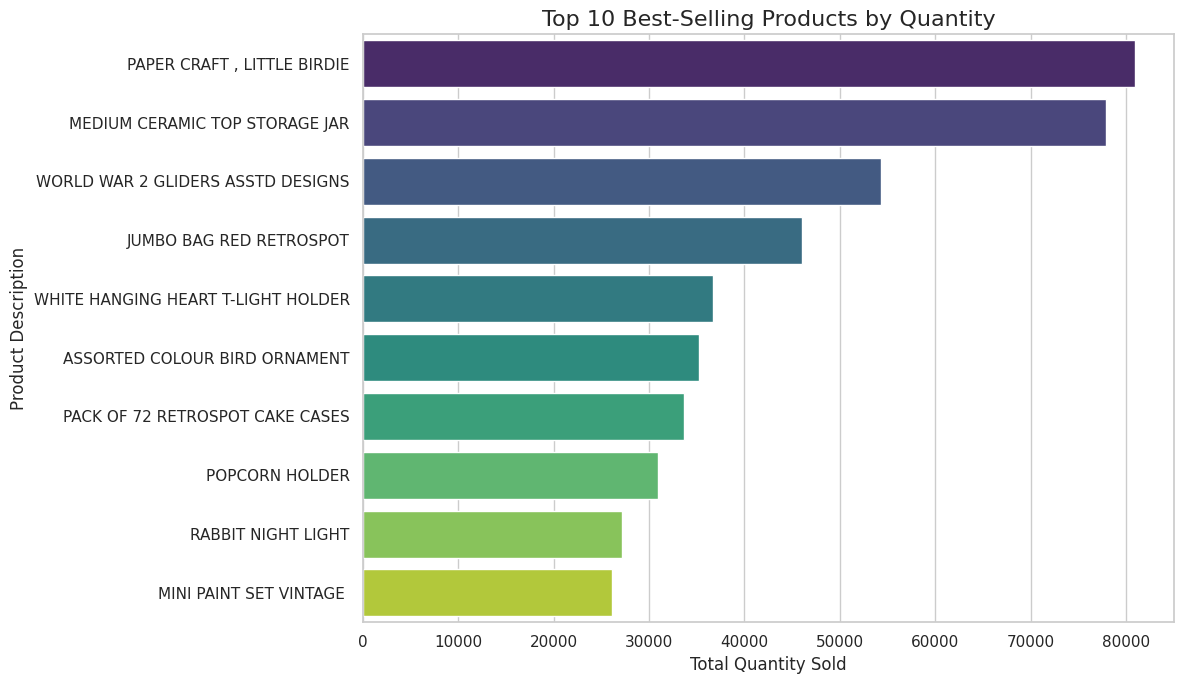

In [21]:
plt.figure(figsize=(12, 7))
sns.barplot(x=top_products_quantity.values, y=top_products_quantity.index, palette='viridis')
plt.title('Top 10 Best-Selling Products by Quantity', fontsize=16)
plt.xlabel('Total Quantity Sold', fontsize=12)
plt.ylabel('Product Description', fontsize=12)
plt.tight_layout();

## Top 10 Best-Selling Products by Revenue

In [22]:
top_products_revenue = df.groupby('Description')['TotalPrice'].sum().sort_values(ascending=False).head(10)
print("\nTop 10 Best-Selling Products by Revenue:")
top_products_revenue.reset_index()


Top 10 Best-Selling Products by Revenue:


,Description,TotalPrice
0,"PAPER CRAFT , LITTLE BIRDIE",168469.60
1,REGENCY CAKESTAND 3 TIER,142264.75
2,WHITE HANGING HEART T-LIGHT HOLDER,100392.10
3,JUMBO BAG RED RETROSPOT,85040.54
4,MEDIUM CERAMIC TOP STORAGE JAR,81416.73
5,POSTAGE,77803.96
6,PARTY BUNTING,68785.23
7,ASSORTED COLOUR BIRD ORNAMENT,56413.03
8,Manual,53419.93
9,RABBIT NIGHT LIGHT,51251.24


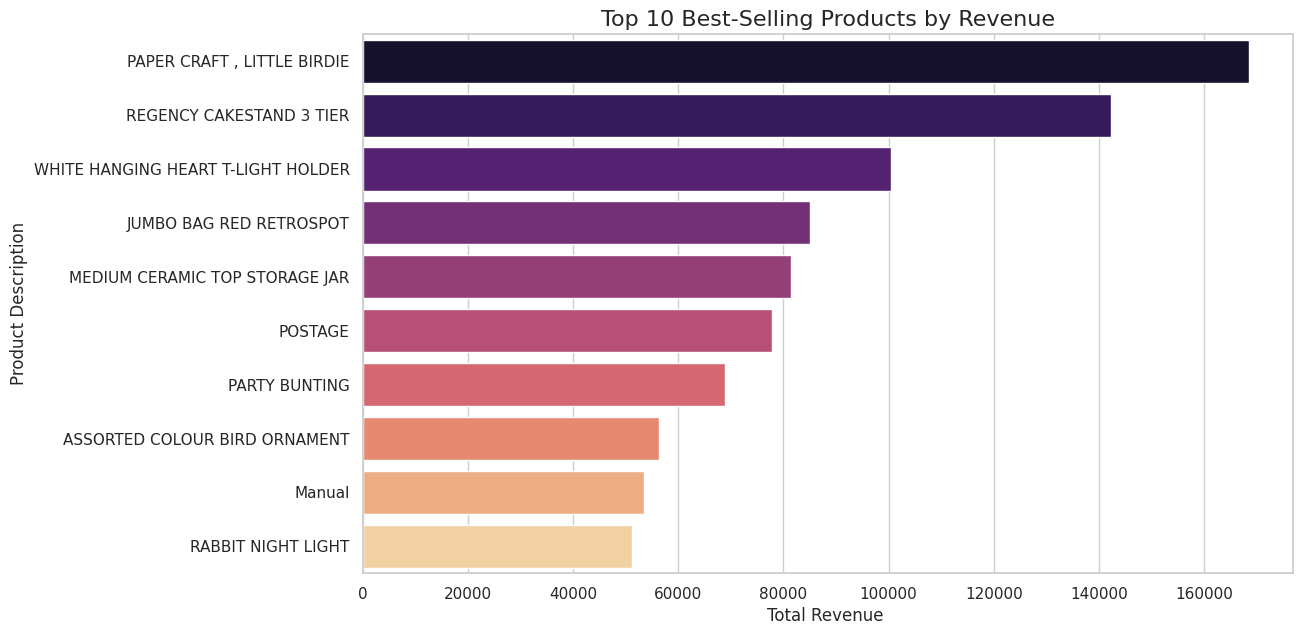

In [23]:
plt.figure(figsize=(12, 7))
sns.barplot(x=top_products_revenue.values, y=top_products_revenue.index, palette='magma')
plt.title('Top 10 Best-Selling Products by Revenue', fontsize=16)
plt.xlabel('Total Revenue ', fontsize=12)
plt.ylabel('Product Description', fontsize=12);

## Top 10 Countries by Total Sales (Excluding UK)

* UK dominates all other country for Top 10 hence excluded in plot

In [24]:
country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False)

country_sales_no_uk = country_sales.drop('United Kingdom')
print("\nTop 10 Countries by Total Sales:")
country_sales.reset_index().head(11)


Top 10 Countries by Total Sales:


,Country,TotalPrice
0,United Kingdom,7285024.644
1,Netherlands,285446.340
2,EIRE,265262.460
3,Germany,228678.400
4,France,208934.310
5,Australia,138453.810
6,Spain,61558.560
7,Switzerland,56443.950
8,Belgium,41196.340
9,Sweden,38367.830


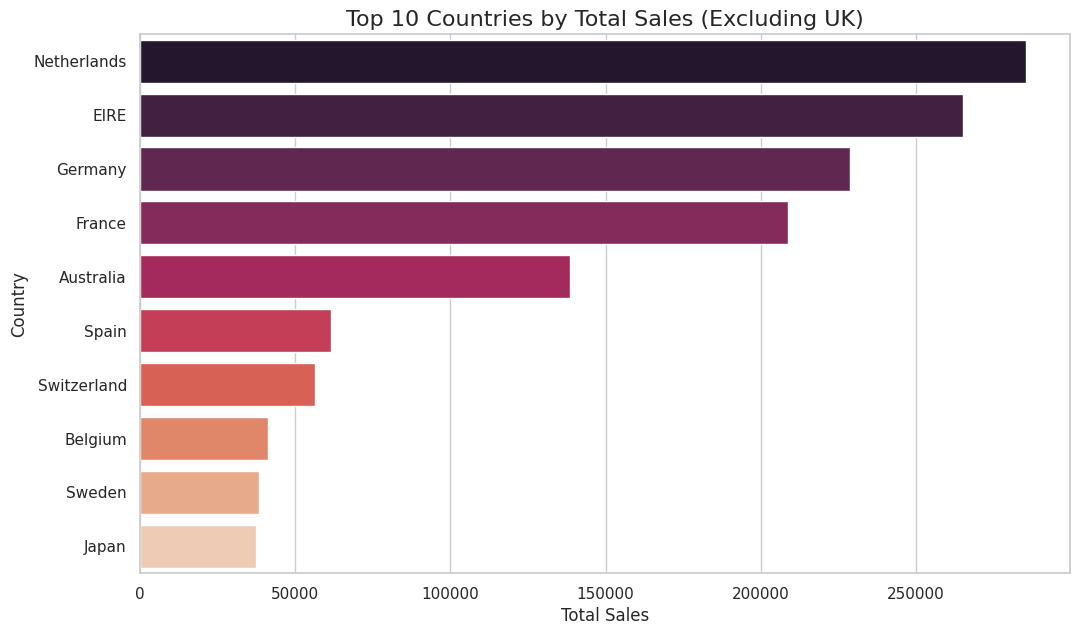

In [25]:
plt.figure(figsize=(12, 7))
sns.barplot(x=country_sales_no_uk.head(10).values, y=country_sales_no_uk.head(10).index, palette='rocket')
plt.title('Top 10 Countries by Total Sales (Excluding UK)', fontsize=16)
plt.xlabel('Total Sales', fontsize=12)
plt.ylabel('Country', fontsize=12);

# 5. RFM Analysis (Recency, Frequency, Monetary)

* RFM analysis is a customer segmentation technique that groups customers based on their past purchasing behavior.
* It's widely used in marketing and customer relationship management (CRM) to identify a company's best customers and to predict future customer behavior.


### RFM stands for three key metrics:

* **Recency (R):**

***What it means:*** How recently a customer has made a purchase.

***Why it's important:*** Customers who have purchased recently are more likely to respond to promotions and buy again compared to those who bought a long time ago. A lower recency value (meaning a more recent purchase) is generally considered better.

* **Frequency (F):**

***What it means:*** How often a customer makes purchases.

***Why it's important:*** Customers who buy frequently are more engaged and loyal. A higher frequency value indicates a more active customer.

* **Monetary Value (M):**

***What it means:*** How much money a customer spends.

***Why it's important:*** Customers who spend more contribute more to the business's revenue. A higher monetary value indicates a more valuable customer.

## RFM Metric Calculation

#### Snapshot Date
* The snapshot date is the point in time from which you calculate Recency.
* It's usually one day after the last transaction date in dataset to ensure all customers have a Recency of at least 1 day.

In [26]:
snapshot_date = df['InvoiceDate'].max() + timedelta(days=1)
print(f"Using snapshot date for RFM: {snapshot_date}")

Using snapshot date for RFM: 2011-12-10 12:50:00


In [27]:
rfm_df = df.groupby('CustomerID').agg(
    Recency=('InvoiceDate', lambda date: (snapshot_date - date.max()).days), # Days since last purchase
    Frequency=('InvoiceNo', 'nunique'),                                    # Number of unique purchases
    Monetary=('TotalPrice', 'sum')                                         # Total spending
).reset_index()
rfm_df.head(2)

,CustomerID,Recency,Frequency,Monetary
0,12346,326,1,77183.6
1,12347,2,7,4310.0


In [28]:
rfm_df.describe()

,CustomerID,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,15300.408022,92.536422,4.272015,2048.688081
std,1721.808492,100.014169,7.697998,8985.230220
min,12346.000000,1.000000,1.000000,3.750000
25%,13813.250000,18.000000,1.000000,306.482500
50%,15299.500000,51.000000,2.000000,668.570000
75%,16778.750000,142.000000,5.000000,1660.597500
max,18287.000000,374.000000,209.000000,280206.020000


## RFM Score Assignment

#### Calculate Recency score (R-score)

* At first qcut gives range of 0 to N-1 according to quantile values.
* Then the value is reversed i.e low recency higher R-score.
* 0 mapped as 4 and 3 mapped as 1 when reversed

In [29]:
rfm_df['R_Score_temp'] = pd.qcut(rfm_df['Recency'], q=4, labels=False, duplicates='drop')
max_r_score_temp = rfm_df['R_Score_temp'].max()
rfm_df['R_Score'] = (max_r_score_temp - rfm_df['R_Score_temp']) + 1

#### Calculate Frequency Score (F-score)

* Here qcut gave only 3 values.
* It's common to have more numbers of one time customer.
* Hence it automatically divides data in 3 quantile due to imbalance.
* Higher F-score for higher frequency of customers.

In [30]:
rfm_df['F_Score_temp'] = pd.qcut(rfm_df['Frequency'], q=4, labels=False, duplicates='drop')
rfm_df['F_Score'] = rfm_df['F_Score_temp'] + 1               # Converts 0,1,2 to 1,2,3



#### Calculate Monetary Score (M-score)

* Customer who spends more have Higher M-score.
* 1 for lowest spender and 4 for highest spender.

In [31]:
rfm_df['M_Score_temp'] = pd.qcut(rfm_df['Monetary'], q=4, labels=False, duplicates='drop')
rfm_df['M_Score'] = rfm_df['M_Score_temp'] + 1         # Converts 0,1,2,3 to 1,2,3,4
rfm_df.head(3)

,CustomerID,Recency,Frequency,Monetary,R_Score_temp,R_Score,F_Score_temp,F_Score,M_Score_temp,M_Score
0,12346,326,1,77183.60,3,1,0,1,3,4
1,12347,2,7,4310.00,0,4,2,3,3,4
2,12348,75,4,1797.24,2,2,1,2,3,4


## Customer Segmentation 


* Drop temporary score column.
* Join all score as string
* Function to segment customer according to their RFM score
*  Apply function to RFM table

In [32]:
rfm_df.drop(columns=['R_Score_temp', 'F_Score_temp', 'M_Score_temp'], inplace=True)

rfm_df['RFM_Segment'] = rfm_df['R_Score'].astype(str) + rfm_df['F_Score'].astype(str) + rfm_df['M_Score'].astype(str)


def rfm_level(df_row):
    r = df_row['R_Score']
    f = df_row['F_Score']
    m = df_row['M_Score']

    if r == 4 and f == 4 and m == 4:
        # These are your best customers: most recently (R=4), buy most frequently (F=4) and spend the most (M=4).
        return 'Champions'  
    elif (r >= 3 and f >= 3 and m >= 3) and not (r == 4 and f == 4 and m == 4):
        # These customers are generally good across all metrics (scores of 3 or higher), but not quite 'Champions'. 
        return 'Loyal Customers'
    elif r >= 4 and f >= 3:
        # Potential Loyalists (Recent, good freq, whatever monetary)
        return 'Potential Loyalists'
    elif r >= 3 and m >= 3: 
        # Big Spenders (Good Recency, good Monetary, less freq)
        return 'Big Spenders'
    elif r <= 2 and f <= 2 and m <= 2: 
        # Lost Customers (Low across all)
        return 'Lost Customers'
    elif r >= 3 and f <= 2 and m <= 2: 
        # About to Sleep (Good Recency, but low F&M)
        return 'About to Sleep'
    else:
        return 'Others'

rfm_df['Customer_Segment'] = rfm_df.apply(rfm_level, axis=1)
rfm_df['Customer_Segment'].value_counts().reset_index()


,Customer_Segment,count
0,Lost Customers,1431
1,Loyal Customers,754
2,About to Sleep,730
3,Others,719
4,Big Spenders,700
5,Potential Loyalists,4


## Distribution of Customer Segments


* Plot and Visualize customer segments

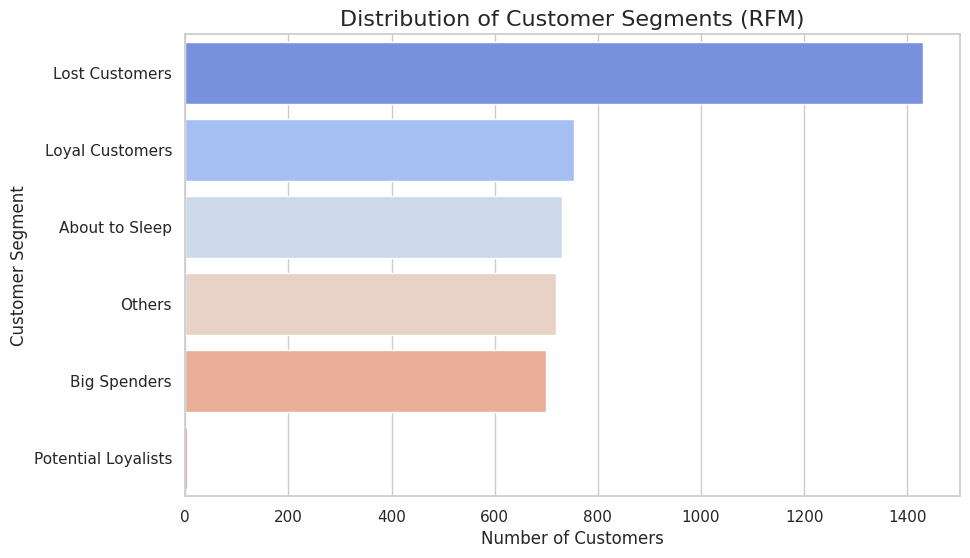

In [33]:
plt.figure(figsize=(10, 6))
sns.countplot(y='Customer_Segment', data=rfm_df, order=rfm_df['Customer_Segment'].value_counts().index, palette='coolwarm')
plt.title('Distribution of Customer Segments (RFM)', fontsize=16)
plt.xlabel('Number of Customers', fontsize=12)
plt.ylabel('Customer Segment', fontsize=12);

plt.savefig("rfm_bar_chart.png", bbox_inches='tight')


# 6. Conclusion and Recommendations 


## Summary of Key Insights

### 1. Sales Trends:

- The online retail store experiences significant seasonality, with November and December being the peak sales months.
- Sales are generally higher during weekdays (especially Tuesday and Thursday) and lower on weekends.
- The busiest hours for sales are typically between 10 AM and 3 PM.")

### 2. Popular Products:

- Certain products, like 'JUMBO BAG RED RETROSPOT' and 'REGENCY CAKESTAND 3 TIER', consistently rank high in both quantity sold and revenue generated, indicating strong customer demand.

### 3. Customer Behavior & Value:

- The store has a diverse customer base, with a large number of unique customers.
- RFM analysis reveals distinct customer segments, including 'Champions' (recently purchased, frequent, high spenders) and 'Loyal Customers'.
- A significant portion of revenue comes from a smaller segment of highly engaged customers (e.g., Champions, Loyal Customers).
- Countries outside the UK, such as Netherlands and EIRE, contribute significantly to sales, often with higher average order values.


## Data-Driven Recommendations


### 1. Optimize Marketing & Promotions:


- **Seasonal Campaigns:** Intensify marketing efforts and product promotions during peak months (November-December) to maximize sales. Consider early-bird offers for holiday shopping.
- **Weekday Focus:** Tailor promotional emails or flash sales for weekdays to capitalize on higher engagement, perhaps focusing on 'lunch break' or 'afternoon slump' hours.


### 2. Inventory & Product Management:


- **Stock Management:** Ensure sufficient stock for top-selling products, especially during peak seasons, to avoid stockouts and lost sales.
- **Bundling & Cross-Selling:** Bundle popular items with less popular ones, or suggest complementary products during checkout to increase average order value.


### 3. Customer Relationship Management (CRM):


- **Loyalty Programs:** Develop and reward 'Champions' and 'Loyal Customers' with exclusive offers, early access to sales, or personalized recommendations to foster continued engagement.
- **Re-engagement Campaigns:** Implement targeted campaigns for 'Needs Attention' or 'Lost Customers' (from RFM analysis) with incentives to encourage return purchases.
- **International Strategy:** Explore specific marketing strategies or localized product offerings for high-performing international markets like Germany and France.")


### 4. Website/App Optimization:


- **Peak Hour Performance:** Ensure the website/app can handle high traffic volumes during busy hours (10 AM - 3 PM) to prevent slow loading times or crashes.
- **Personalized Recommendations:** Leverage purchase history to offer personalized product recommendations, particularly for 'Loyal Customers' and 'Champions'.

### This analysis provides a foundational understanding of the online retail store's performance and customer base.

### Further deep-dives, A/B testing, and predictive modeling could build upon these insights.